In [ ]:
!pip install geopandas
!apt install libspatialindex-dev
!pip install rtree
!pip install pygeos
!pip install pysal
!pip install osmtogeojson

     |████████████████████████████████| 972kB 6.0MB/s 
     |████████████████████████████████| 14.8MB 317kB/s 
     |████████████████████████████████| 6.5MB 50.4MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 14 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 1s (656 kB/s)
Selecting previously un

  Created wheel for osmtogeojson: filename=osmtogeojson-0.0.2-cp36-none-any.whl size=4072 sha256=6e6b331aa05ec1eb4bf709c961b916674545c57d26f76322b4ab32e4ed34aea0
  Stored in directory: /root/.cache/pip/wheels/66/8f/b9/3d6a6b99dad98d578bb3bcbd3ddc7dbf12ae526e028e4c1a8f
Successfully built osmtogeojson


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import geopandas as gpd
import shapely
import requests
from osmtogeojson import osmtogeojson
from tqdm.notebook import tqdm
from geopy.geocoders import Nominatim
from geopy import distance
import matplotlib.pyplot as plt
import re

import folium
from folium.plugins import HeatMap

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

### Задача:

Прогноз продаж одной из популярных моделей [фичерфонов](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D1%87%D0%B5%D1%80%D1%84%D0%BE%D0%BD) (на картинке ниже пример похожего устройства) в салонах МегаФона
![](https://39.img.avito.st/640x480/8468720439.jpg)

### Исходные данные:

Датасет содержит следующие поля:

1. `point_id` - Индентификатор салона
2. `lon` - Долгота точки
3. `lat` - Широта точки
4. `target` - Значение таргета, усредненное за несколько месяцев и отнормированное

### Требования к решению и советы:

Ниже приведен список из нескольких важных пунктов, необходимых для решения задания. Выполнение каждого из пунктов влияет на итоговую оценку. Вы можете выполнить каждый из пунктов разными способами, самым лучшим будет считаться вариант, когда всё получение и обработка данных будут реализованы на Питоне (пример: вы можете скачать данные из OSM через интерфейс на сайте overpass-turbo или с помощью библиотек `overpass`/`requests`. Оба варианта будут зачтены, но больше баллов можно заработать во втором случае)



1. Салоны расположены в нескольких разных городах, вам необходимо **определить город для каждого салона** (это понадобится во многих частях задания). К этому есть разные подходы. Вы можете провести [обратное геокодирование](https://en.wikipedia.org/wiki/Reverse_geocoding) с помощью геокодера [Nominatim](https://nominatim.org/), доступного через библиотеку `geopy` примерно вот так:
```python
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.reverse("52.509669, 13.376294")
print(location.address)
```
В таком случае, вам придется обрабатывать полученную строку адреса, чтобы извлечь название города. Также вы можете скачать из OSM или найти в любом другом источнике границы административно территориальных границ России и пересечь с ними датасет с помощью `geopandas.sjoin` (этот вариант более надежный, но нужно будет разобраться с тем, как устроены границы АТД в OSM, обратите внимание на [этот тег](https://wiki.openstreetmap.org/wiki/Key:admin_level))


2. **Используйте данные OSM**: подумайте, какие объекты могут влиять на продажи фичерфонов. Гипотеза: такие телефоны покупают люди, приезжающие в город или страну ненадолго, чтобы вставить туда отдельную симкарту для роуминга. Можно попробовать использовать местоположения железнодорожных вокзалов (изучите [этот тег](https://wiki.openstreetmap.org/wiki/Tag:railway%3Dstation)). Необходимо использовать хотя бы 5 разных типов объектов из OSM. Скорее всего, вам придется качать данные OSM отдельно для разных городов (см. пример для Нью-Йорка из лекции)


3. **Используйте разные способы генерации признаков**: описать положение салона МегаФона относительно станций метро можно разными способами - найти ***расстояние до ближайшей станции***, или же посчитать, сколько станций попадает в ***500 метровую буферную зону*** вокруг салона. Такие признаки будут нести разную информацию. Так же попробуйте поэкспериментировать с размерами буферных зон (представьте, что значат в реальности радиусы 100, 500, 1000 метров). Попробуйте посчитать расстояние до центра города, до других объектов.

4. **Сделайте визуализации**: постройте 2-3 карты для какого нибудь из городов - как распределен в пространстве таргет, где находятся объекты, полученные вами из OSM. Можете использовать любой инструмент - обычный `plot()`, `folium`, `keplergl`. Если выберете Кеплер, обязательно сохраните в файл конфиг карты, чтобы ее можно было воспроизвести. Сделать это можно вот так:

```python
import json
json_data = kepler_map.config
with open('kepler_config.json', 'w') as outfile:
    json.dump(json_data, outfile)
```
5. Задание не ограничено приведенными выше пунктами, попробуйте нагенерировать интересных признаков, найти в интернете дополнительные данные (в таком случае в комментарии к коду укажите ссылку на ресурс, откуда взяли данные)



6. Это довольно сложная задача - датасет очень маленький, данные по своей природе довольно случайны. Поэтому место и скор на Kaggle не будут играть решающую роль в оценке, но позволят заработать дополнительные баллы

### Read data

### Пункт 1. Определим город для каждого салона.
### Для этого я использовал Nominatim. Я скачивал сырые данные для каждых координат и затем из них доставал информацию о городе или населенном пункте. Так как это происходит достаточно долго, я сохранил эту информацию в отдельные файлы, чтобы не ждать загрузки каждый раз заново.
Так же я пробовал делать это с помощью OSM, но были проблемы с полигонами некоторых городов. Некоторые города скачивались как надо, полигонами, некоторые в виде linestring, а некоторые в виде GeometryCollection. С linestring я еще разобрался, но GeometryCollection я не смог осилить и поэтому вернулся к способу с Nomimatim

In [ ]:
# train = pd.read_csv('mf_geo_train.csv')
# test = pd.read_csv('mf_geo_test.csv')

In [ ]:
# train.head(2)

In [ ]:
# user_agent_ ='Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.185 YaBrowser/20.11.2.80 Yowser/2.5 Safari/537.36'
# geolocator = Nominatim(scheme='http', timeout=30, user_agent=user_agent_)

In [ ]:
# addresses_train = {}
# addresses = []
# for i in tqdm(range(len(train[['lat', 'lon']].values))):
#     adr = geolocator.reverse(train[['lat', 'lon']].values[i])
#     addresses_train[i] = adr.raw
#     addresses.append(adr.address)
# train['address'] = addresses

In [ ]:
# for i, j in addresses_train.items():
#     if 'city' in j['address'].keys():
#         print(i, j['address']['city'])
#     elif 'town' in j['address'].keys():
#         print(i, j['address']['town'])
#     elif 'village' in j['address'].keys():
#         print(i, j['address']['village'])

In [ ]:
# cities_train = []
# for i, j in addresses_train.items():
#     if 'city' in j['address'].keys():
#         cities_train.append(j['address']['city'])
#     elif 'town' in j['address'].keys():
#         cities_train.append(j['address']['town'])
#     elif 'village' in j['address'].keys():
#         cities_train.append(j['address']['village'])
# train['city'] = cities_train

In [ ]:
# addresses_test = {}
# addresses = []
# for i in tqdm(range(len(test[['lat', 'lon']].values))):
#     adr = geolocator.reverse(test[['lat', 'lon']].values[i])
#     addresses_test[i] = adr.raw
#     addresses.append(adr.address)
# test['address'] = addresses

In [ ]:
# for i, j in addresses_test.items():
#     if 'city' in j['address'].keys():
#         print(i, j['address']['city'])
#         marker_test.append('city')
#     elif 'town' in j['address'].keys():
#         print(i, j['address']['town'])
#         marker_test.append('town')
#     elif 'village' in j['address'].keys():
#         print(i, j['address']['village'])
#         marker_test.append('village')

In [ ]:
# cities_test = []
# for i, j in addresses_test.items():
#     if 'city' in j['address'].keys():
#         cities_test.append(j['address']['city'])
#     elif 'town' in j['address'].keys():
#         cities_test.append(j['address']['town'])
#     elif 'village' in j['address'].keys():
#         cities_test.append(j['address']['village'])
# test['city'] = cities_test

In [ ]:
# train.to_csv('./addrcitied_train.csv', index=False)
# test.to_csv('./addrcitied_test.csv', index=False)

In [ ]:
train = pd.read_csv('addrcitied_train.csv')
test = pd.read_csv('addrcitied_test.csv')

In [ ]:
train.head(3)

,point_id,lon,lat,target,address,city
0,ommNZCUV,37.590776,55.848630,-0.348157,"6А, Сигнальный проезд, район Отрадное, Москва,...",Москва
1,nMe2LHPb,37.784210,55.750271,1.294206,"38/18, 2-я Владимирская улица, Владимирский по...",Москва
2,ZgodVRqB,39.635721,47.213330,-1.039679,"18, улица Зорге, 10-й мкр, ЗЖМ, Советский райо...",Ростов-на-Дону


### Пункт 2. Создание дополнительных признаков с помощью OSM.
Я скачал данные всех ЖД станций, и искал расстояние от каждой точки до каждой станции и записывал наименьшее расстояние. Также записал количество станций в пределах 500 метров.

In [ ]:
query = """
[out:json][timeout:300];
area(3600060189);
(
  node["railway"="station"](area);
  way["railway"="station"](area);
  relation["railway"="station"](area);
);
out body;
>;
out skel qt;
"""
url = "http://overpass-api.de/api/interpreter"
r = requests.get(url, params={'data': query})

result = osmtogeojson.process_osm_json(r.json())

In [ ]:
stations = {}
for i in result['features']:
    try:
        stations[i['properties']['name'] + ' ' + i['properties']['@id']] = shapely.geometry.Point(i['geometry']['coordinates'])
    except:
        stations[i['properties']['@id']] = shapely.geometry.Point(i['geometry']['coordinates'])

In [ ]:
stations = gpd.GeoDataFrame({'geometry':stations.values()})

In [ ]:
train_points = []
for i in train[['lon', 'lat']].values:
    train_points.append(shapely.geometry.Point(i))

test_points = []
for i in test[['lon', 'lat']].values:
    test_points.append(shapely.geometry.Point(i))

In [ ]:
train['geometry'] = train_points
test['geometry'] = test_points
train = gpd.GeoDataFrame(train)
test = gpd.GeoDataFrame(test)

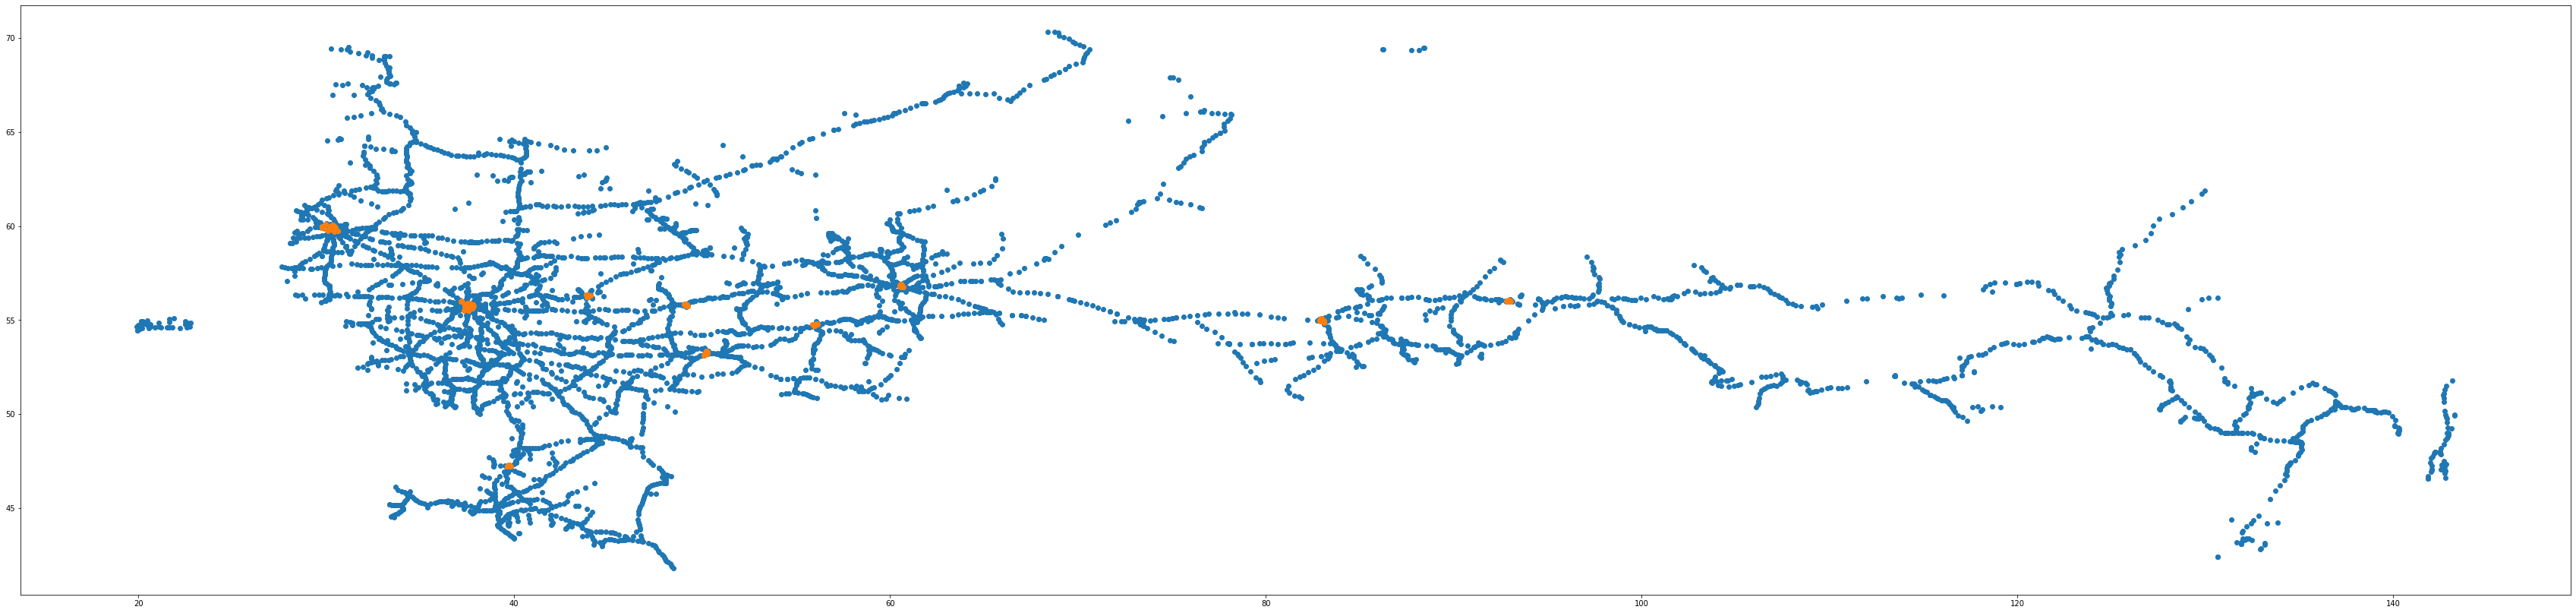

In [ ]:
fig = plt.figure(figsize=(60.20, 40.80))
ax = plt.axes()
stations.plot(ax=ax)
train.plot(ax=ax)

In [ ]:
train_new = train.set_crs(4326)
train_new = train_new.to_crs(epsg=32618)

test_new = test.set_crs(4326)
test_new = test_new.to_crs(epsg=32618)

stations_new = stations.set_crs(4326)
stations_new = stations_new.to_crs(epsg=32618)

In [ ]:
radius = 0.1 # радиус в котором смотрим количество станций, 100 метров показал себя лучше

In [ ]:
closest = []
clos_num = []
for i, point in enumerate(train_new.geometry.values):
    distances = []
    num = 0
    for station in stations_new.geometry.values:
        distance = point.distance(station) / 1000
        distances.append(distance)
        if distance <= radius:
            num += 1
    closest_station_distance = np.min(distances)
    closest.append(closest_station_distance)
    clos_num.append(num)
train['clos_st_dist'] = closest
train['close_500_num'] = clos_num

In [ ]:
closest = []
clos_num = []
for i, point in enumerate(test_new.geometry.values):
    distances = []
    num = 0
    for station in stations_new.geometry.values:
        distance = point.distance(station) / 1000
        distances.append(distance)
        if distance <= radius:
            num += 1
    closest_station_distance = np.min(distances)
    closest.append(closest_station_distance)
    clos_num.append(num)
test['clos_st_dist'] = closest
test['close_500_num'] = clos_num

In [ ]:
train

,point_id,lon,lat,target,address,city,geometry,clos_st_dist,close_500_num
0,ommNZCUV,37.590776,55.848630,-0.348157,"6А, Сигнальный проезд, район Отрадное, Москва,...",Москва,POINT (37.59078 55.84863),0.186289,2
1,nMe2LHPb,37.784210,55.750271,1.294206,"38/18, 2-я Владимирская улица, Владимирский по...",Москва,POINT (37.78421 55.75027),0.205819,1
2,ZgodVRqB,39.635721,47.213330,-1.039679,"18, улица Зорге, 10-й мкр, ЗЖМ, Советский райо...",Ростов-на-Дону,POINT (39.63572 47.21333),3.241355,0
3,0t2jNYdz,37.704570,55.782020,-1.169339,"Торговый центр ""Серебряный Дом"", 16, Большая С...",Москва,POINT (37.70457 55.78202),0.069446,1
4,U27W4QJ7,37.643983,55.730188,-0.088837,"5, Кожевническая улица, Швивая горка, район За...",Москва,POINT (37.64398 55.73019),0.259479,2
...,...,...,...,...,...,...,...,...,...
420,AA8hN7bJ,37.628765,55.740664,0.213704,"31 с3, Пятницкая улица, 20-24, район Замосквор...",Москва,POINT (37.62877 55.74066),0.102662,3
421,uNw6t6xk,37.586825,55.794233,-0.002397,"2/18, Бутырская улица, Бутырский район, Москва...",Москва,POINT (37.58682 55.79423),0.195993,3
422,Ap42ei8k,37.678790,55.772910,-0.910019,"33/2 с1, Бауманская улица, Бауманка, Москва, Ц...",Москва,POINT (37.67879 55.77291),0.133261,1
423,rn9A8r62,37.752130,55.619640,-0.326547,"6, Кустанайская улица, Зябликово, район Зяблик...",Москва,POINT (37.75213 55.61964),0.646836,0


### Пункт 3. Создание различных признаков, используя OSM.
Для начала я наивно скачаю центры всех городов и просто посчитаю расстояние от каждой точки до ближайшего города, буду использовать это как признак.
Также посчитал расстояние до ближайшего салона связи и количество салонов в радиусе 500 метров. Но эти признаки не дают особого прироста, если не делют хуже.

In [ ]:
query = """
[out:json][timeout:300];
area(3600060189);
(
  node["place"="city"](area);
);
out body;
>;
out skel qt;
"""
url = "http://overpass-api.de/api/interpreter"
r = requests.get(url, params={'data': query})

result = osmtogeojson.process_osm_json(r.json())

In [ ]:
cities = {}
for i in result['features']:
    cities[i['properties']['name']] = shapely.geometry.Point(i['geometry']['coordinates'])

In [ ]:
cities = gpd.GeoDataFrame({'geometry':cities.values()})

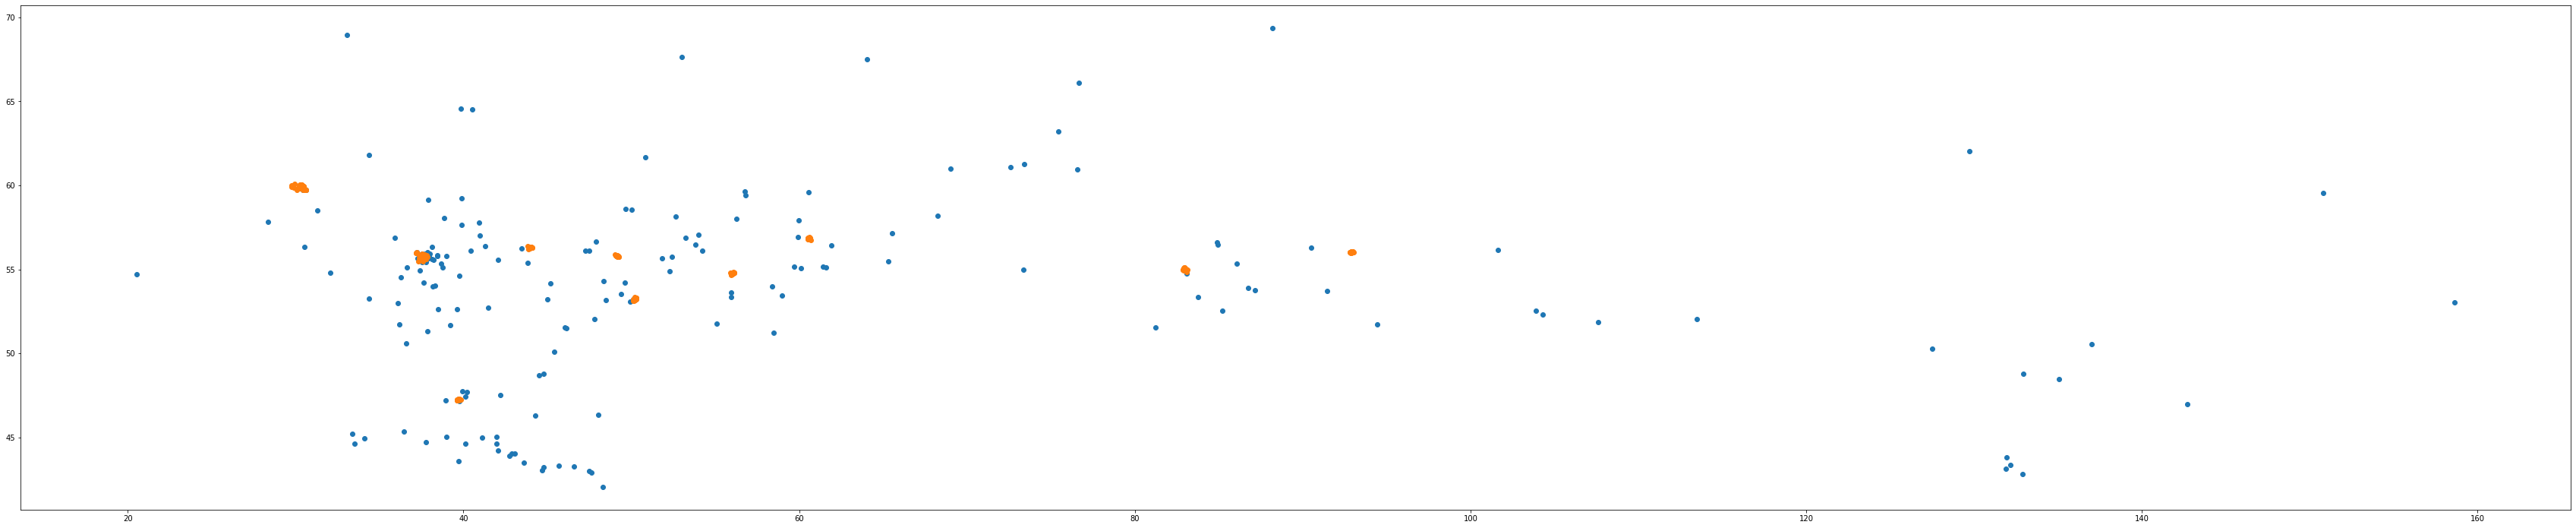

In [ ]:
fig = plt.figure(figsize=(60.20, 40.80))
ax = plt.axes()
cities.plot(ax=ax)
train.plot(ax=ax)

In [ ]:
cities_new = cities.set_crs(4326)
cities_new = cities_new.to_crs(epsg=32618)

In [ ]:
closest = []
for i, point in enumerate(train_new.geometry.values):
    distances = []
    for city in cities_new.geometry.values:
        distance = point.distance(city) / 1000
        distances.append(distance)
    closest_city_distance = np.min(distances)
    closest.append(closest_city_distance)
train['city_dist'] = closest

In [ ]:
train['is_moscow'] = [1 if i == 'Москва' or i == 'Санкт-Петербург' else 0 for i in train['city'].values] # бинарный признак Москва или Санкт-Петербург это или нет

In [ ]:
closest = []
closest_num = []
for i, point in enumerate(train_new.geometry.values):
    distances = []
    num = -1 # сам с собой
    for p in train_new.geometry.values:
        distance = point.distance(p) / 1000
        distances.append(distance)
        if distance < 0.5:
            num += 1
    closest_mob_shop_distance = np.sort(distances)[1]
    closest.append(closest_mob_shop_distance)
    closest_num.append(num)
train['shop_dist'] = closest
train['shop_num'] = closest_num

In [ ]:
train

,point_id,lon,lat,target,address,city,geometry,clos_st_dist,close_500_num,city_dist,is_moscow,shop_dist,shop_num
0,ommNZCUV,37.590776,55.848630,-0.348157,"6А, Сигнальный проезд, район Отрадное, Москва,...",Москва,POINT (37.59078 55.84863),0.186289,2,11.905070,1,0.575093,0
1,nMe2LHPb,37.784210,55.750271,1.294206,"38/18, 2-я Владимирская улица, Владимирский по...",Москва,POINT (37.78421 55.75027),0.205819,1,12.241460,1,0.105369,1
2,ZgodVRqB,39.635721,47.213330,-1.039679,"18, улица Зорге, 10-й мкр, ЗЖМ, Советский райо...",Ростов-на-Дону,POINT (39.63572 47.21333),3.241355,0,7.369985,0,0.874965,0
3,0t2jNYdz,37.704570,55.782020,-1.169339,"Торговый центр ""Серебряный Дом"", 16, Большая С...",Москва,POINT (37.70457 55.78202),0.069446,1,7.598580,1,0.149655,1
4,U27W4QJ7,37.643983,55.730188,-0.088837,"5, Кожевническая улица, Швивая горка, район За...",Москва,POINT (37.64398 55.73019),0.259479,2,3.278233,1,0.651178,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,AA8hN7bJ,37.628765,55.740664,0.213704,"31 с3, Пятницкая улица, 20-24, район Замосквор...",Москва,POINT (37.62877 55.74066),0.102662,3,1.519239,1,1.124532,0
421,uNw6t6xk,37.586825,55.794233,-0.002397,"2/18, Бутырская улица, Бутырский район, Москва...",Москва,POINT (37.58682 55.79423),0.195993,3,6.129182,1,0.287298,1
422,Ap42ei8k,37.678790,55.772910,-0.910019,"33/2 с1, Бауманская улица, Бауманка, Москва, Ц...",Москва,POINT (37.67879 55.77291),0.133261,1,5.366584,1,0.086473,1
423,rn9A8r62,37.752130,55.619640,-0.326547,"6, Кустанайская улица, Зябликово, район Зяблик...",Москва,POINT (37.75213 55.61964),0.646836,0,12.933855,1,1.035579,0


## Пунтк 4. Визуализации

In [ ]:
query = """
[out:json][timeout:300];
area(3602555133);
(
  //way["place"="city"](area);
  relation["place"="city"](area);
);
out body;
>;
out skel qt;
"""
url = "http://overpass-api.de/api/interpreter"
r = requests.get(url, params={'data': query})

result = osmtogeojson.process_osm_json(r.json())

In [ ]:
def linestring_to_polygon(linestring):
    geom = [x for x in linestring]
    all_coords = shapely.geometry.mapping(geom[0])['coordinates']
    lats = [x[1] for x in all_coords]
    lons = [x[0] for x in all_coords]
    polyg = shapely.geometry.Polygon(zip(lons, lats))
    return polyg

In [ ]:
moscow = shapely.geometry.MultiLineString(result['features'][0]['geometry']['coordinates'])
moscow = linestring_to_polygon(moscow)
moscow = gpd.GeoDataFrame({'geometry':moscow}, index=[0])

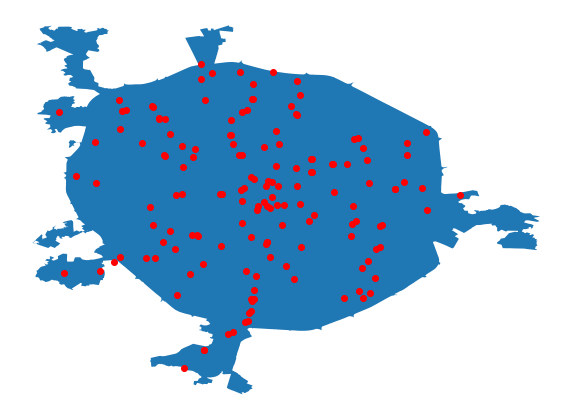

In [ ]:
fig = plt.figure(figsize=(10, 15))
ax = plt.axes()
moscow.plot(ax=ax)
train[train['city']=='Москва'].plot(ax=ax, color='red')
plt.axis('off')
plt.show()

In [ ]:
m = folium.Map(location=[55.7504461, 37.6174943], 
               zoom_start=11, 
               tiles='cartodbpositron')

heat_data = [[row['lat'],row['lon']] for index, row in train.iterrows()]


HeatMap(heat_data,
        radius=10).add_to(m)

m

### Fit model

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train.drop(['target', 'city', 'address', 'point_id', 'geometry'], axis=1), train[['target']])
model = LinearRegression(normalize=True).fit(X_train, y_train)

In [ ]:
X_train

,lon,lat,clos_st_dist,close_500_num,city_dist,is_moscow,shop_dist,shop_num
272,83.094496,54.840236,3.409562,0,9.411043,0,14.431292,0
360,43.864996,56.243009,0.506420,0,14.658892,0,1.357839,0
180,37.478132,55.854933,0.140869,0,5.085312,1,0.123176,1
148,49.192958,55.744566,1.292153,0,6.806102,0,1.190475,0
237,37.622612,55.729331,0.088082,1,2.775414,1,0.395959,1
...,...,...,...,...,...,...,...,...
358,37.664147,55.731865,0.127248,0,4.195311,1,1.497779,0
119,37.411720,55.647053,1.550684,0,10.714548,1,2.020952,0
306,30.273976,59.900058,0.044884,1,5.610637,1,1.775904,0
197,50.238669,53.251547,4.402195,0,11.690137,0,1.112390,0


In [ ]:
model.coef_

array([[ 0.00260297, -0.09146262, -0.06944134,  0.23646393,  0.01245934,
         0.15677137,  0.06827252,  0.25749651]])

In [ ]:
mean_absolute_error(y_valid, model.predict(X_valid))

0.6470854092854136

### Make submission

In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = model.predict(X_valid)
submission.to_csv('my_submission_01.csv', index=False)